In [1]:
import bw2data as bd
import bw2calc as bc
import stats_arrays as sa
import flodym as fd
import flodym.export as fde
import pandas as pd
import logging

14:02:01+0100 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


In [2]:
# -------------------------------------------------------
# 1️⃣ Flodym: Define and compute MFA
# -------------------------------------------------------
dimension_definitions = [
    fd.DimensionDefinition(letter="s", name="substance", items=(["DM", "water"]), dtype=str),
]

In [3]:
parameter_definitions = [
    fd.ParameterDefinition(name="dm allocation", dim_letters=("s",)),
    fd.ParameterDefinition(name="water allocation", dim_letters=("s",)),
    fd.ParameterDefinition(name="manure", dim_letters=("s",)),
]

In [4]:
process_names = [
    "sysenv",
    "dewatering",
    "storage",
    "soil application",
]

In [5]:
flow_definitions = [
    fd.FlowDefinition(from_process_name="sysenv", to_process_name="dewatering", dim_letters=(["s"])),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="soil application", dim_letters=(["s"])),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="storage", dim_letters=(["s"])),
    fd.FlowDefinition(from_process_name="soil application", to_process_name="sysenv", dim_letters=(["s"])),
    fd.FlowDefinition(from_process_name="storage", to_process_name="sysenv", dim_letters=(["s"])),
]

In [6]:
stock_definitions = [
    fd.StockDefinition(
        name="dummy",
        dim_letters=("s",),
        subclass=fd.SimpleFlowDrivenStock,
        time_letter="s",
    ),
]

In [7]:
mfa_definition = fd.MFADefinition(
    dimensions=dimension_definitions,
    parameters=parameter_definitions,
    processes=process_names,
    flows=flow_definitions,
    stocks=stock_definitions,
)

In [8]:
dimension_files = {
    "substance": "data/dimension_substance.csv",
}
parameter_files = {
    "dm allocation": "data/parameter_DM_allocation.csv",
    "water allocation": "data/parameter_water_allocation.csv",
    "manure": "data/parameter_manure.csv",
}

In [9]:
class SimpleMFA(fd.MFASystem):
    def compute(self):
        self.flows["sysenv => dewatering"][...] = self.parameters["manure"]
        self.flows["dewatering => soil application"][...] = self.flows["sysenv => dewatering"] * self.parameters["dm allocation"]
        self.flows["dewatering => storage"][...] = self.flows["sysenv => dewatering"] * self.parameters["water allocation"]
        self.flows["soil application => sysenv"][...] = self.flows["dewatering => soil application"]
        self.flows["storage => sysenv"][...] = self.flows["dewatering => storage"]

mfa_manure = SimpleMFA.from_csv(
    definition=mfa_definition,
    dimension_files=dimension_files,
    parameter_files=parameter_files,
)
mfa_manure.compute()
import logging 
logger = logging.getLogger() 
logger.setLevel(logging.INFO)
mfa_manure.check_mass_balance()

INFO:root:Checking mass balance of SimpleMFA object...
INFO:root:Success - Mass balance is consistent!


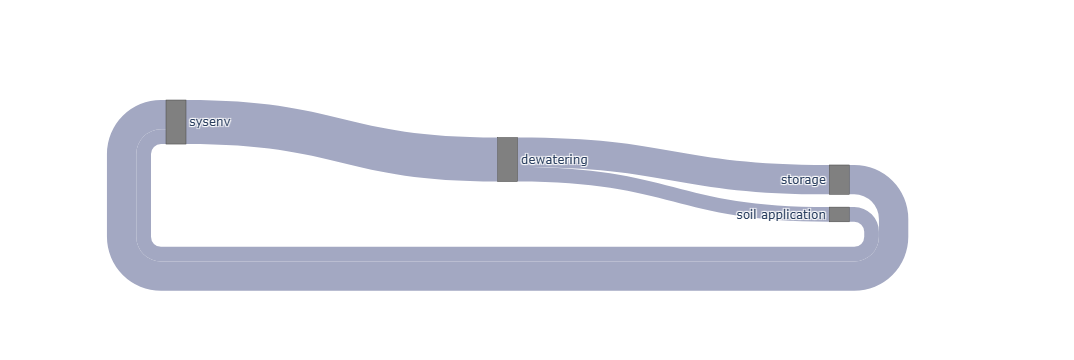

In [10]:
# Optional: visualize
import flodym.export as fde 
fig = fde.PlotlySankeyPlotter(mfa=mfa_manure, exclude_processes=[]).plot() 
fig.show()

In [11]:
# Extract flow results
manure_amount = float(mfa_manure.flows["sysenv => dewatering"].values.sum())
fiber_amount = float(mfa_manure.flows["dewatering => soil application"].values.sum())
liquid_amount = float(mfa_manure.flows["dewatering => storage"].values.sum())

print(f"MFA results: manure={manure_amount}, fiber={fiber_amount}, liquid={liquid_amount}")

MFA results: manure=3.0, fiber=1.0, liquid=2.0


In [12]:
# -------------------------------------------------------
# 2️⃣ Brightway: Build database using MFA results
# -------------------------------------------------------
bd.projects.set_current('ecoinvent-3.11-cutoff-bw25')
if "manure" in bd.databases:
    del bd.databases["manure"]

db = bd.Database("manure")
db.register()

In [13]:
sorted(bd.databases)

['ecoinvent-3.11-biosphere', 'ecoinvent-3.11-cutoff', 'manure']

In [14]:
# --- Product nodes ---
manure = db.new_node(name="manure", unit="tonne", type=bd.labels.product_node_default)
fiber = db.new_node(name="fiber", unit="tonne", type=bd.labels.product_node_default)
liquid = db.new_node(name="liquid", unit="tonne", type=bd.labels.product_node_default)
electricity = bd.get_node(
    database='ecoinvent-3.11-cutoff',
    name='market for electricity, medium voltage',
    location='DK',
)

In [15]:
# --- Process nodes ---
dewatering = db.new_node(name="dewatering", type=bd.labels.process_node_default, location="DK")
storage = db.new_node(name="storage", type=bd.labels.process_node_default, location="DK")
soil_application = db.new_node(name="soil application", type=bd.labels.process_node_default, location="DK")

In [16]:
# --- Biosphere flow ---
ch4 = bd.get_node(
    database='ecoinvent-3.11-biosphere',
    name='Methane, non-fossil',
    categories=('air',),
)

In [17]:
# --- Save all nodes ---
for n in [manure, fiber, liquid, electricity, dewatering,
          storage, soil_application, ch4]:
    n.save()

In [18]:
# --- Reference productions ---
#manure_source.new_edge(amount=manure_amount, input=manure, type=bd.labels.production_edge_default, functional=True).save()
dewatering.new_edge(amount=liquid_amount, input=liquid, type=bd.labels.production_edge_default, functional=True).save()
dewatering.new_edge(amount=fiber_amount, input=fiber, type=bd.labels.production_edge_default, functional=False).save()
soil_application.new_edge(amount=fiber_amount, input=fiber, type=bd.labels.consumption_edge_default, functional=False).save()

In [19]:
# --- Technosphere flows (from MFA) ---
dewatering.new_edge(amount=manure_amount, input=manure, type=bd.labels.consumption_edge_default, functional=False).save()
dewatering.new_edge(amount=1000, input=electricity, type=bd.labels.consumption_edge_default, functional=False).save()  # example electricity use
storage.new_edge(amount=liquid_amount, input=liquid, type=bd.labels.consumption_edge_default, functional=False).save()
soil_application.new_edge(amount=fiber_amount, input=fiber, type=bd.labels.consumption_edge_default, functional=False).save()

In [20]:
# --- Biosphere emissions ---
storage.new_edge(amount=1, uncertainty_type=5, minimum=0.5, maximum=1.50,
                 input=ch4, type=bd.labels.biosphere_edge_default).save()

In [21]:
for node in bd.Database('manure'):
    print(node)

'soil application' (None, DK, None)
'fiber' (tonne, GLO, None)
'storage' (None, DK, None)
'dewatering' (None, DK, None)
'liquid' (tonne, GLO, None)
'manure' (tonne, GLO, None)


In [22]:
my_method = bd.Method(
    ('ecoinvent-3.11', 
     'CML v4.8 2016', 
     'climate change', 
     'global warming potential (GWP100)')
)
my_method

Brightway2 Method: ecoinvent-3.11: CML v4.8 2016: climate change: global warming potential (GWP100)

In [23]:
# -------------------------------------------------------
# 3️⃣ LCA calculation (example)
# -------------------------------------------------------

functional_unit, data_objs, _ = bd.prepare_lca_inputs({manure: -1}, method=('ecoinvent-3.11', 
     'CML v4.8 2016', 
     'climate change', 
     'global warming potential (GWP100)'), remapping=True)
lca = bc.LCA(demand=functional_unit, data_objs=data_objs)
lca.lci()
lca.lcia()
print("LCIA score:", lca.score)

INFO:bw2calc:Initialized LCA object. Demand: {247345429845295104: -1}, data_objs: [<bw_processing.datapackage.Datapackage object at 0x72a92485e450>, <bw_processing.datapackage.Datapackage object at 0x72a924889580>, <bw_processing.datapackage.Datapackage object at 0x72a9248b45f0>, <bw_processing.datapackage.Datapackage object at 0x72a925f96fc0>]


LCIA score: 68.77616940686404
